Packages

In [70]:
#modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

#configuration
pd.set_option('display.max_columns', None)

Extracting Data from csvs and turning into Pandas Data frame

In [71]:
oil = pd.read_csv("data/oil.csv")
holidays = pd.read_csv("data/holidays_events.csv")
stores = pd.read_csv("data/stores.csv")
test = pd.read_csv("data/test.csv")
train = pd.read_csv("data/train.csv")
transactions = pd.read_csv("data/transactions.csv")

transactions.sort_values(['store_nbr', 'date'])

,date,store_nbr,transactions
1,2013-01-02,1,2111
47,2013-01-03,1,1833
93,2013-01-04,1,1863
139,2013-01-05,1,1509
185,2013-01-06,1,520
...,...,...,...
83271,2017-08-11,54,768
83325,2017-08-12,54,903
83379,2017-08-13,54,1054
83433,2017-08-14,54,818


Convert date columns in dataframe to date time format

In [72]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
holidays['date'] = pd.to_datetime(holidays['date'])
transactions['date'] = pd.to_datetime(transactions['date'])
oil['date'] = pd.to_datetime(oil['date'])

Check for NaN Values

In [73]:
print(oil.isna().sum())
print(holidays.isna().sum())
print(stores.isna().sum())
print(test.isna().sum())
print(train.isna().sum())
print(transactions.isna().sum())

date           0
dcoilwtico    43
dtype: int64
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64
id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64
date            0
store_nbr       0
transactions    0
dtype: int64


Print Oil data frame and replace NaN values with next day oil price

        date  dcoilwtico
0 2013-01-01       93.14
1 2013-01-02       93.14
2 2013-01-03       92.97
3 2013-01-04       93.12
4 2013-01-07       93.20
1218


C:\Users\Eric\AppData\Local\Temp\ipykernel_4688\558941655.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  oil.fillna(method='bfill', inplace=True)


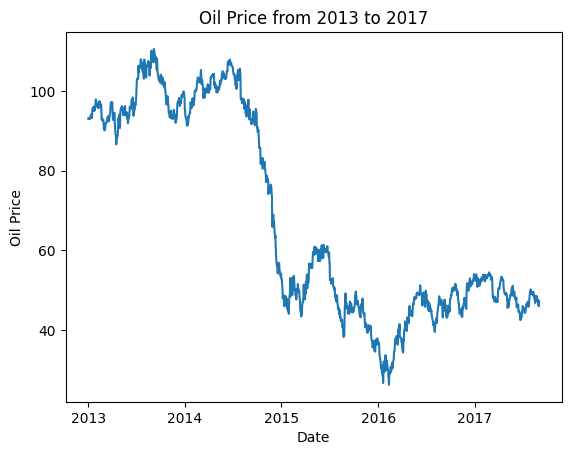

In [74]:
oil.fillna(method='bfill', inplace=True)
print(oil.head())
print(len(oil))
plt.plot(oil["date"], oil["dcoilwtico"])
plt.title("Oil Price from 2013 to 2017")
plt.xlabel("Date")
plt.ylabel("Oil Price")
plt.show()